# LSTM gesture classifier

In addition to the materials from the course, I watched the following video on the number of parameters in LSTM's.
https://www.youtube.com/watch?v=B08baRr2LlY - LSTM: Understanding the Number of Parameters

The lstm_demo.ipynb from the course was used as a template, which I then expanded for my purposes.

All results have been saved in the 'task_two_results' folder.
It contains the plotted results of the history, the configuration matrices and the results of the predictions for each variant.

I chose the values ​​16, 32, 64, 128, 256 for the systematic comparison of different values ​​for 'number of parameters'.
We used the value 64 in the exercise. That's why I wanted to increase and decrease the value twice. Always by half in order to get a systematic difference between the values ​​and to be able to compare them better.

## Report

### Comparison between the number of parameter variants

With regard to the accuracy, all variants reached the value of 0.99. However, variants 16, 32 and 64 required over 17 epochs, while variant 128 only required 14 epochs and 256 only 10 epochs.
The predictions for all variants were correct. In terms of the time required, all variants needed about 3.4 - 3.7 miliseconds , with variant 16 and 256 needing the most time.

All in all the number of parameters has an influence on the model, with a number of more than 128 having an influence how fast the model learns (needing less epochs)

### Comparison with the 1 dollar recognizer

The one dollar recognizer also need about 1 milisecond (on my system), but looking at how shure it is about the prediction (0.7 - 0.9), the lsfm ist more reliable, because it dosent depend on how good the drawing is. Thats the reason why I would choose the LSFM with a number of 128 or 256 over the one dollar recognizer for a practical applicaton.

## Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import uuid
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

# results path
RESULTS_PATH_HISTORY = os.path.abspath('task_two_results/histories/')
RESULTS_PATH_CONFIG_MATRICES = os.path.abspath('task_two_results/config_matrices/')
RESULTS_PATH_PREDICTION_RESULTS = os.path.abspath('task_two_results/prediction_results/')

NUM_POINTS = 50

classes_arr = ['arrow', 'caret', 'check', 'circle', 'delete_mark', 'left_curly_brace', 'left_sq_bracket', 'pigtail', 'question_mark', \
               'rectangle', 'right_curly_brace', 'right_sq_bracket', 'star', 'triangle', 'v', 'x']

inference_time_arr = []
param_count_variants_arr = []
predictions_outcome_arr = []

## Training Data (remaining data)

In [2]:
data = []

for root, subdirs, files in os.walk('dataset'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                data.append((label, resampled))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

In [3]:
print(data[0])

('arrow', array([[-1.98115675,  1.98053787],
       [-2.06546475,  1.99436522],
       [-1.93086964,  1.8442288 ],
       [-1.90192736,  1.76971743],
       [-1.78875077,  1.71317545],
       [-1.71781591,  1.57516255],
       [-1.57514812,  1.43563976],
       [-1.58042064,  1.39580667],
       [-1.34995696,  1.18830922],
       [-1.19546419,  0.99642441],
       [-0.960359  ,  0.83813815],
       [-0.78288021,  0.61858763],
       [-0.52384061,  0.46002859],
       [-0.32284315,  0.28639652],
       [-0.08225056,  0.0972638 ],
       [ 0.13539409, -0.04098562],
       [ 0.28665714, -0.18479149],
       [ 0.38552463, -0.22181367],
       [ 0.54906291, -0.37553448],
       [ 0.62910992, -0.43764128],
       [ 0.77023395, -0.53465178],
       [ 0.81775568, -0.56226704],
       [ 0.89772108, -0.61428591],
       [ 0.7960657 , -0.65419655],
       [ 0.7157478 , -0.69746153],
       [ 0.5429837 , -0.65135589],
       [ 0.34374538, -0.64974188],
       [ 0.22664267, -0.6529458 ],
       [ 0

## validation data (10 gestures for each class)

In [4]:
validation_data = []

for class_label in classes_arr:
    counter = 0
    for i in range(len(data)):
        if counter < 10:
            if data[i][0] == class_label:
                validation_data.append(data[i])
                del data[i]
                counter += 1
        else:
            break

In [5]:
print(validation_data[0])

('arrow', array([[-1.98115675,  1.98053787],
       [-2.06546475,  1.99436522],
       [-1.93086964,  1.8442288 ],
       [-1.90192736,  1.76971743],
       [-1.78875077,  1.71317545],
       [-1.71781591,  1.57516255],
       [-1.57514812,  1.43563976],
       [-1.58042064,  1.39580667],
       [-1.34995696,  1.18830922],
       [-1.19546419,  0.99642441],
       [-0.960359  ,  0.83813815],
       [-0.78288021,  0.61858763],
       [-0.52384061,  0.46002859],
       [-0.32284315,  0.28639652],
       [-0.08225056,  0.0972638 ],
       [ 0.13539409, -0.04098562],
       [ 0.28665714, -0.18479149],
       [ 0.38552463, -0.22181367],
       [ 0.54906291, -0.37553448],
       [ 0.62910992, -0.43764128],
       [ 0.77023395, -0.53465178],
       [ 0.81775568, -0.56226704],
       [ 0.89772108, -0.61428591],
       [ 0.7960657 , -0.65419655],
       [ 0.7157478 , -0.69746153],
       [ 0.5429837 , -0.65135589],
       [ 0.34374538, -0.64974188],
       [ 0.22664267, -0.6529458 ],
       [ 0

## Prepare training data

In [6]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'star', 'right_sq_bracket', 'arrow', 'delete_mark', 'x', 'circle', 'check', 'left_sq_bracket', 'v', 'rectangle', 'question_mark', 'triangle', 'pigtail', 'left_curly_brace', 'caret', 'right_curly_brace'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16
(4096, 50, 2) (1024, 50, 2) (4096, 16) (1024, 16)


## train model method
parameter is a lsfm parameter count variant

In [7]:
def train_model(parameter_count):
    # Define the model
    model = Sequential()

    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates
    model.add(LSTM(parameter_count, input_shape=(NUM_POINTS, 2)))

    # add dense layer to do machine learning magic
    model.add(Dense(32, activation='relu'))

    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
    model.add(Dense(len(set(labels)), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[reduce_lr, stop_early]
    )

    return model, history

## five different versions with systematically differtent LSTM’s parameter counts

In [8]:
# variant 1
model_16, history_16 = train_model(16)
# variant 2
model_32, history_32 = train_model(32)
# variant 3
model_64, history_64 = train_model(64)
# variant 4
model_128, history_128 = train_model(128)
# variant 5
model_256, history_256= train_model(256)

Epoch 1/20
128/128 [==============================] - 2s 7ms/step - loss: 2.3715 - accuracy: 0.2061 - val_loss: 1.7614 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 1s 5ms/step - loss: 1.2156 - accuracy: 0.6660 - val_loss: 0.7492 - val_accuracy: 0.8398 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 1s 5ms/step - loss: 0.5515 - accuracy: 0.8757 - val_loss: 0.3878 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 1s 5ms/step - loss: 0.3087 - accuracy: 0.9255 - val_loss: 0.2370 - val_accuracy: 0.9502 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 1s 5ms/step - loss: 0.1973 - accuracy: 0.9529 - val_loss: 0.1624 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 1s 5ms/step - loss: 0.1517 - accuracy: 0.9663 - val_loss: 0.1112 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 7/20
128/128 [==============================] - 1s 5ms/step - lo

### model summaries

In [9]:
model_16.summary()
model_32.summary()
model_64.summary()
model_128.summary()
model_256.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1216      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
Total params: 2,288
Trainable params: 2,288
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4480      
                                                                 
 dense_2 (Dense)             (No

### plot and save results
saved in 'task_two_results' folder

In [11]:
def plot_history(history, param_count_variant_str):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)
    plt.title(param_count_variant_str)
    plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

    plt.savefig(f"{RESULTS_PATH_HISTORY}\{param_count_variant_str}_results_{uuid.uuid4()}.png", format='png')

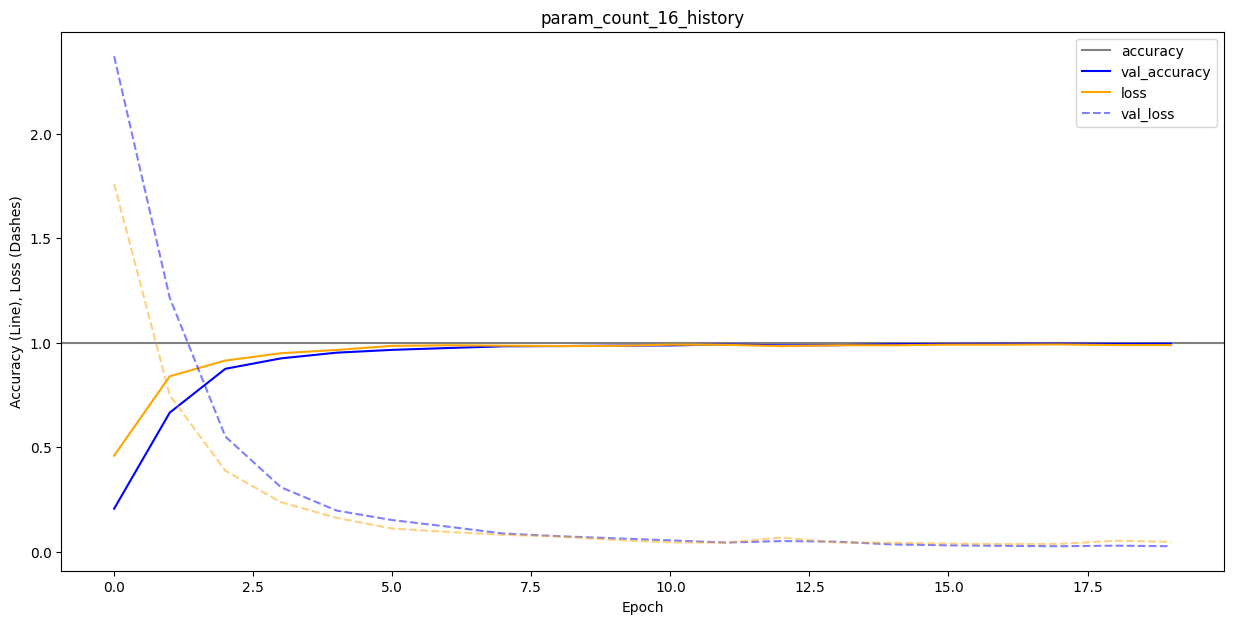

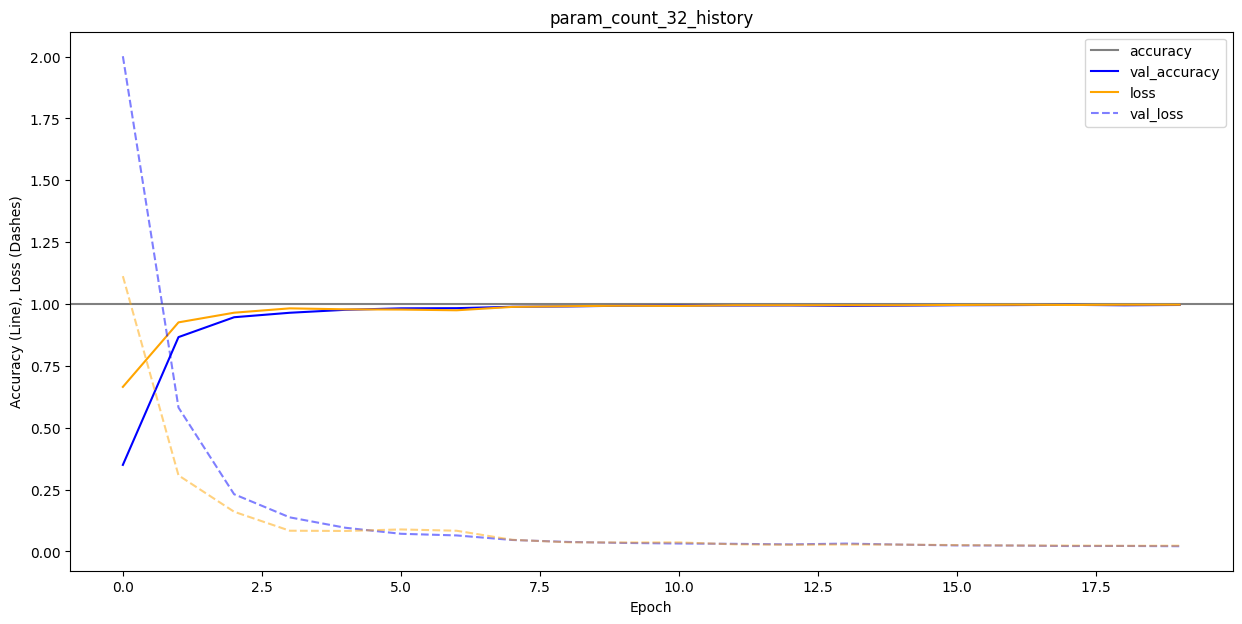

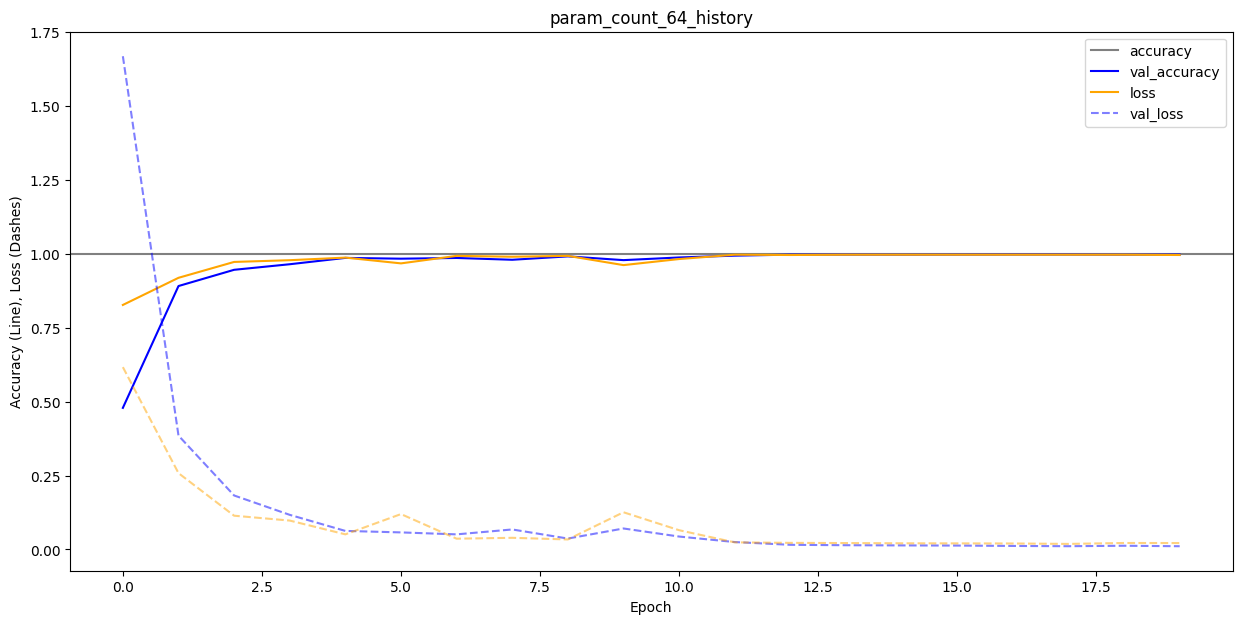

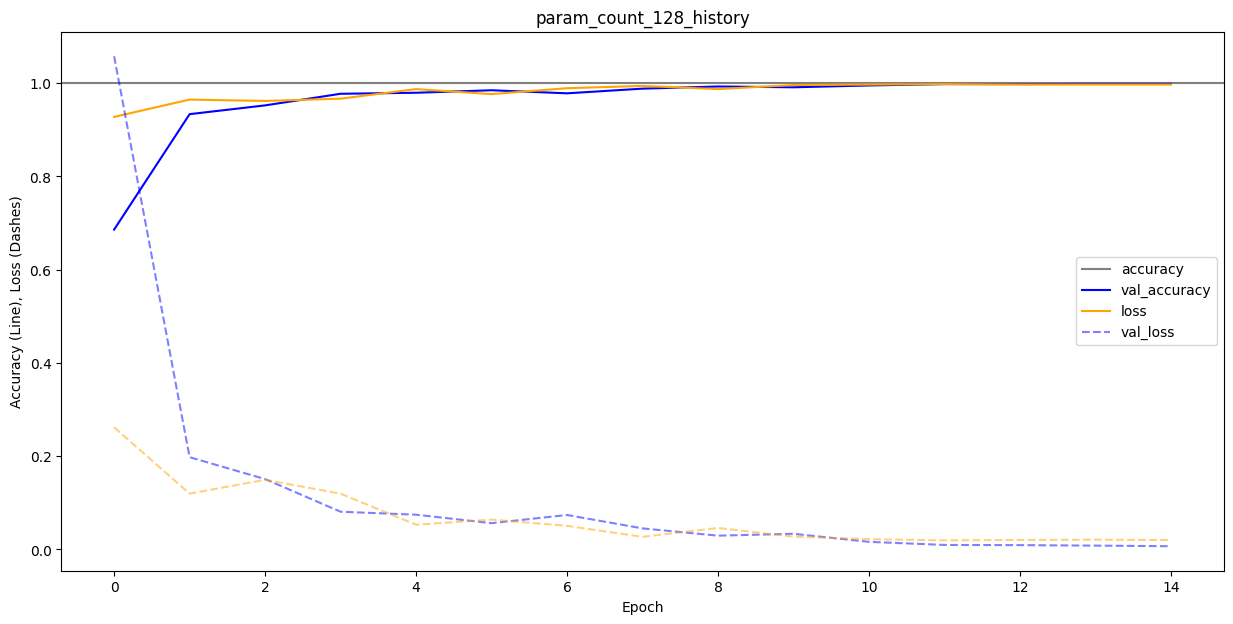

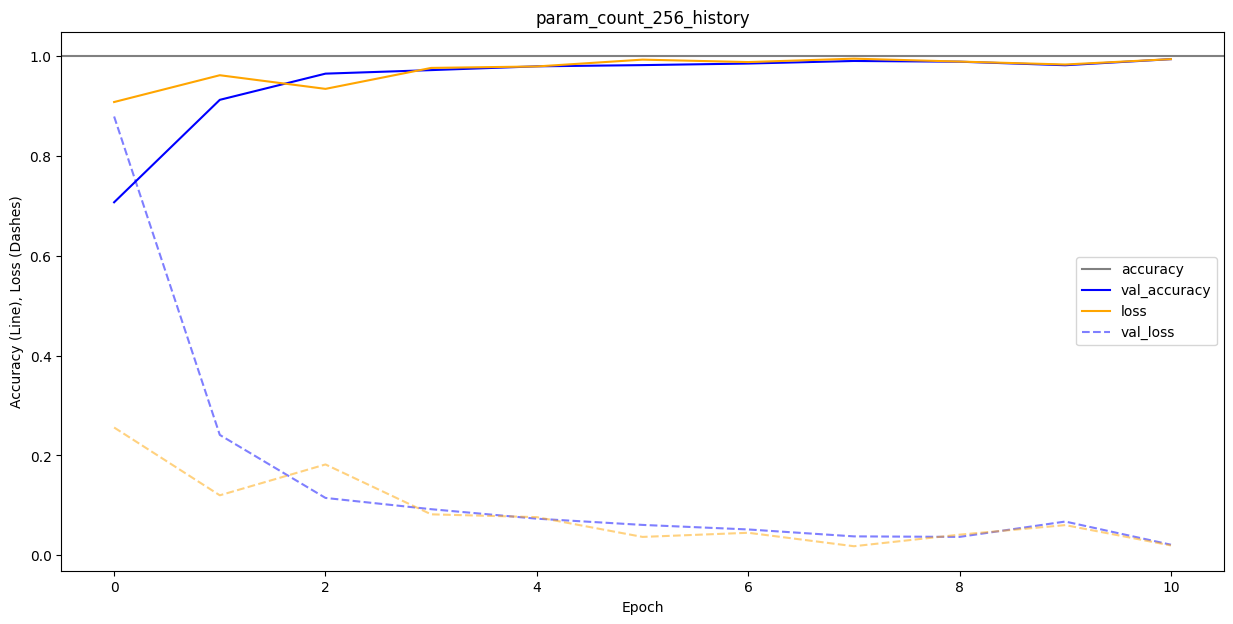

In [12]:
plot_history(history_16, 'param_count_16_history')
plot_history(history_32, 'param_count_32_history')
plot_history(history_64, 'param_count_64_history')
plot_history(history_128, 'param_count_128_history')
plot_history(history_256, 'param_count_256_history')

### prediction test for every model and save the config matrix
resulting configuration matrices are stored in the task_two_results folder

In [13]:
def conf_matrix(model, param_count_variant_str):
    # let the model make predictions for our training data
    y_predictions = model.predict(X_test)

    # to build a confusion matrix, we have to convert it to classifications
    # this can be done by using the argmax() function to set the probability to 1 and the rest to 0
    y_predictions = np.argmax(y_predictions, axis=1)

    y_test_labels = np.argmax(y_test, axis=1)

    # create and plot confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_predictions)

    fig = plt.figure(figsize=(10, 10))

    ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

    plt.xticks(rotation=90, ha='center')
    plt.title(param_count_variant_str + "_config_matrix")
    plt.savefig(f"{RESULTS_PATH_CONFIG_MATRICES}\{param_count_variant_str}_config_matrix_{uuid.uuid4()}.png", format='png')
    pass


32/32 [==============================] - 1s 12ms/step


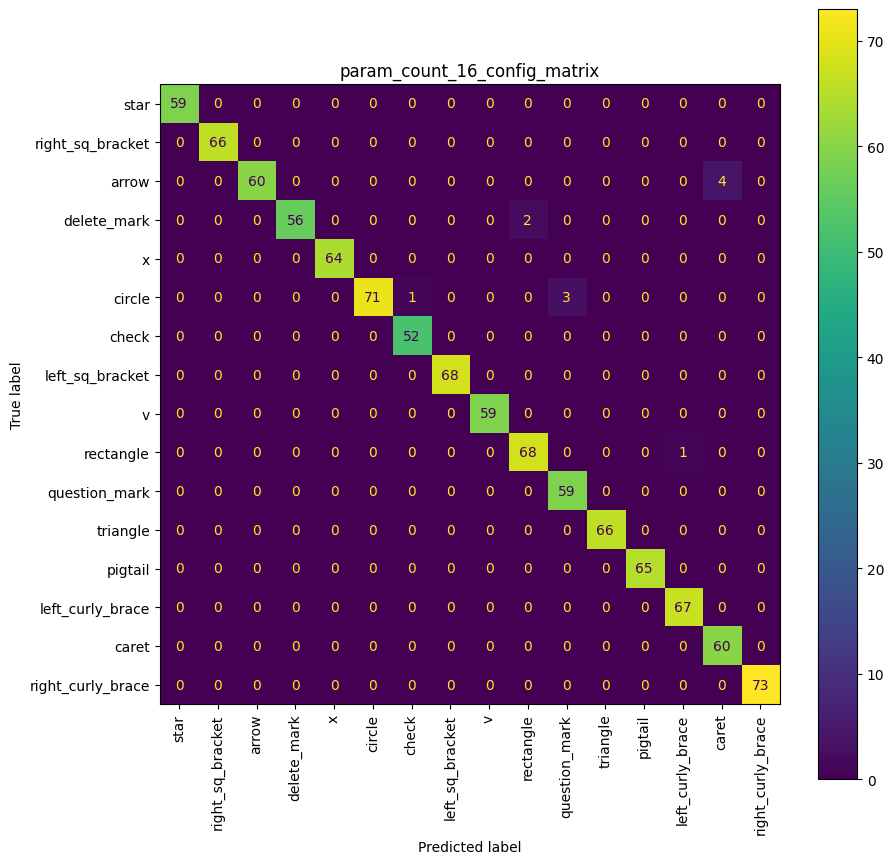

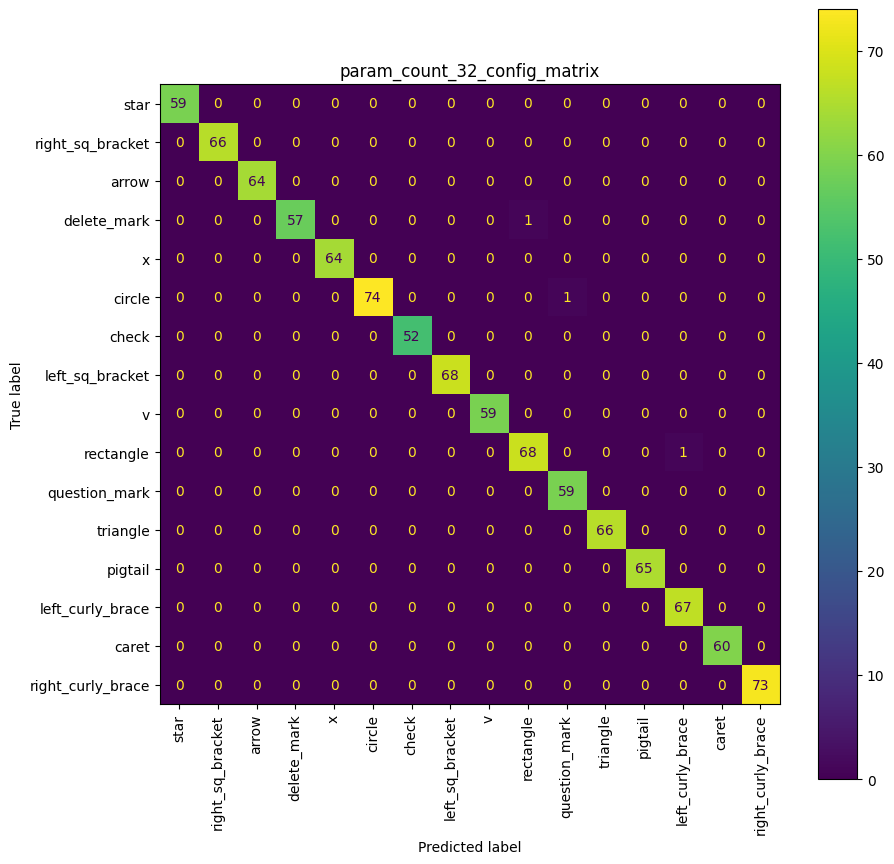

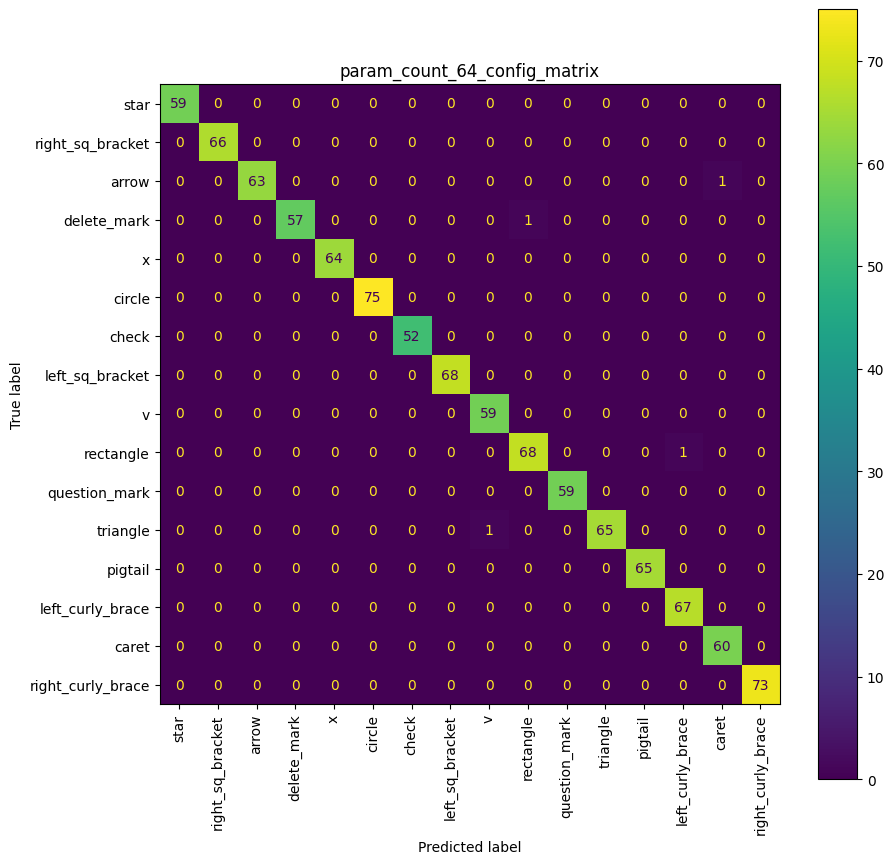

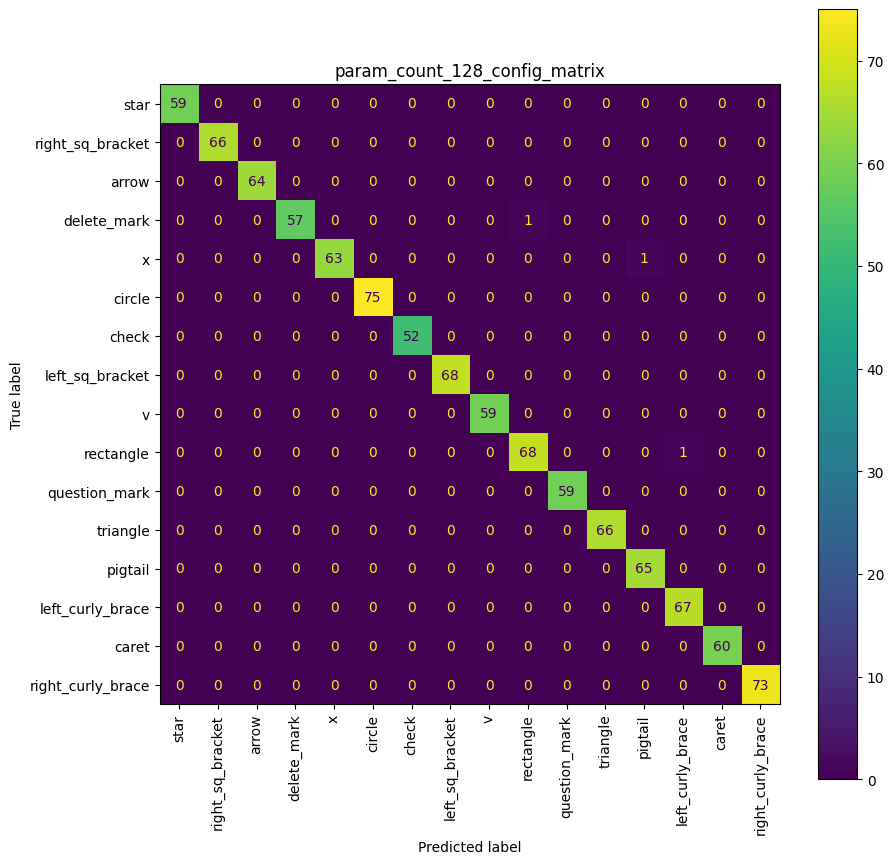

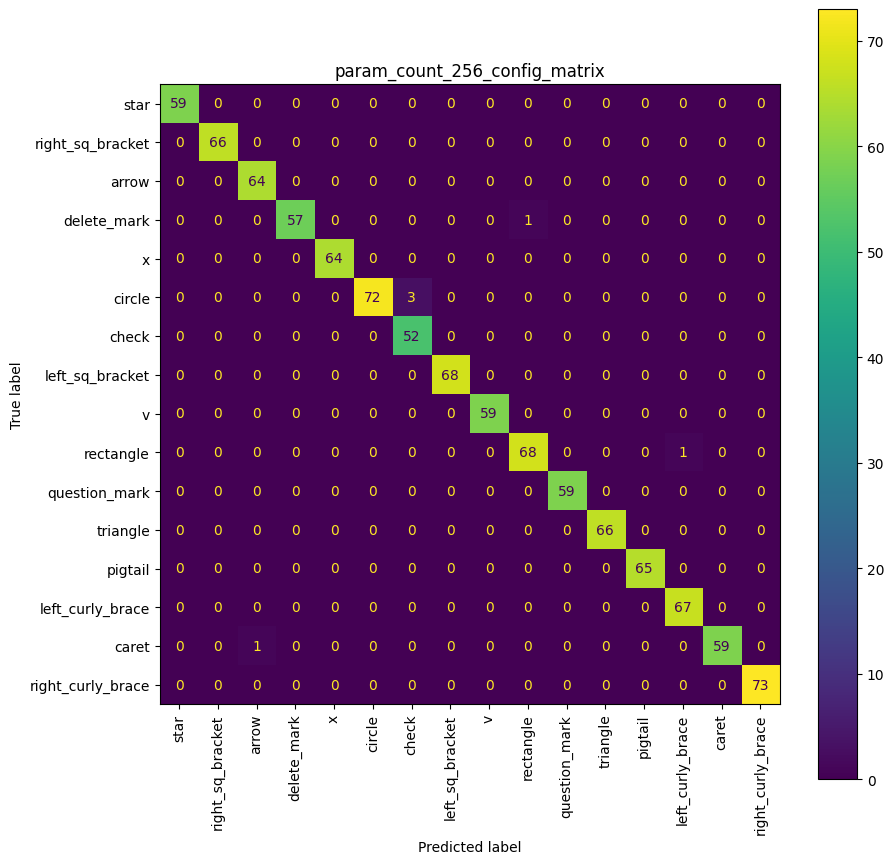

In [14]:
conf_matrix(model_16, 'param_count_16')
conf_matrix(model_32, 'param_count_32')
conf_matrix(model_64, 'param_count_64')
conf_matrix(model_128, 'param_count_128')
conf_matrix(model_256, 'param_count_256')

In [25]:
# method to test the models in action

def predict(model, param_count_variant:str):
    test_data = random.sample(validation_data, 1)[0]

    label = test_data[0]
    sequence = test_data[1]
    #sequence

    start_time = time.time()
    
    prediction = model.predict(np.array([sequence]))
    prediction = np.argmax(prediction)
    prediction_label = encoder.inverse_transform(np.array([prediction]))[0]

    duration = time.time() - start_time
    duration_ms = str((round(duration, 4))) + ' seconds'

    inference_time_arr.append(duration_ms)
    param_count_variants_arr.append(param_count_variant)

    if label == prediction_label:
        predictions_outcome_arr.append("correct")
    else:
        predictions_outcome_arr.append("incorrect")

    print(param_count_variant)
    print('Label:     ', label)
    print('Prediction:', prediction_label)


In [30]:
predict(model_16, 'paramt_count_16_prediction')
predict(model_32, 'paramt_count_32_prediction')
predict(model_64, 'paramt_count_64_prediction')
predict(model_128, 'paramt_count_128_prediction')
predict(model_256, 'paramt_count_256_prediction')

1/1 [==============================] - 0s 14ms/step
paramt_count_16_prediction
Label:      left_curly_brace
Prediction: left_curly_brace
1/1 [==============================] - 0s 14ms/step
paramt_count_32_prediction
Label:      check
Prediction: check
1/1 [==============================] - 0s 17ms/step
paramt_count_64_prediction
Label:      delete_mark
Prediction: delete_mark
1/1 [==============================] - 0s 16ms/step
paramt_count_128_prediction
Label:      right_sq_bracket
Prediction: right_sq_bracket
1/1 [==============================] - 0s 15ms/step
paramt_count_256_prediction
Label:      star
Prediction: star


In [29]:
param_count_variants_arr = []
predictions_outcome_arr = []
inference_time_arr = []

In [31]:
df = pd.DataFrame(list(zip(param_count_variants_arr, predictions_outcome_arr, inference_time_arr)))
df.columns = ['param_count_variant', 'prediction', 'inference_time']
df.to_csv(f"{RESULTS_PATH_PREDICTION_RESULTS}\prediction_results_{uuid.uuid4()}.csv")